In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-01-27 00:29:28'

# wip

In [2]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [5]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [108]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 180)

db1 = DbAccessor('khurram_animal_learning_best_configs', cfg_primary_key="run", timestep_col_name="step", local=False, gc2=True)
db2 = DbAccessor('khurram_lstm_bptt_3', cfg_primary_key="run", timestep_col_name="step", local=False, gc2=True)

In [9]:
pd.read_sql(f'select * from runs', db1.conn)

,features,freq,lambda,name,run,seed,start,step_size,steps,width
0,108,100000000,0.90,animal_learning_best_configs,0,0,100,1e-1,5000000,1000
1,108,100000000,0.90,animal_learning_best_configs,1,1,100,1e-1,5000000,1000
2,108,100000000,0.90,animal_learning_best_configs,2,2,100,1e-1,5000000,1000
3,108,100000000,0.90,animal_learning_best_configs,3,3,100,1e-1,5000000,1000
4,108,100000000,0.90,animal_learning_best_configs,4,4,100,1e-1,5000000,1000
...,...,...,...,...,...,...,...,...,...,...
695,108,100000000,0.99,animal_learning_best_configs,1995,145,100,1e-1,5000000,1000
696,108,100000000,0.99,animal_learning_best_configs,1996,146,100,1e-1,5000000,1000
697,108,100000000,0.99,animal_learning_best_configs,1997,147,100,1e-1,5000000,1000
698,108,100000000,0.99,animal_learning_best_configs,1998,148,100,1e-1,5000000,1000


In [45]:
pd.read_sql(f'select * from runs', db2.conn)

,seed,runs,name,output_dir,run,truncation,features,step_size
0,0.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/0/30_12/,0.0,1.0,33.0,0.3000
1,1.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/0/30_4/,1.0,1.0,33.0,0.3000
2,2.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/0/30_6/,2.0,1.0,33.0,0.3000
3,3.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/0/30_2/,3.0,1.0,33.0,0.3000
4,4.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/0/30_1/,4.0,1.0,33.0,0.3000
...,...,...,...,...,...,...,...,...
1045,25.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/34/30_26/,1045.0,50.0,33.0,0.0003
1046,26.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/34/30_27/,1046.0,50.0,33.0,0.0003
1047,27.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/34/30_28/,1047.0,50.0,33.0,0.0003
1048,28.0,30.0,lstm_bptt_3,../results/25January2022/lstm_bptt_3/34/30_29/,1048.0,50.0,33.0,0.0003


In [106]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if table == 'training_metrics':
        col = 'running_acc'
    elif table == 'error_table' or table == "test_accuracy":
        col = 'error'
    else:
        col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t {len(runs)} runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    linewidth = plt.rcParams["lines.linewidth"]
    if linestyle == ":":
        linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        #plt.plot(x_axis, acc_mean, label=f"{label} | runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.3, color=color)
    return True

In [65]:
pd.read_sql(f'describe error_table', db1.conn)
pd.read_sql(f'show tables', db2.conn)
pd.read_sql(f'describe error_table', db2.conn)

,Field,Type,Null,Key,Default,Extra
0,run,double,NO,PRI,None,
1,step,double,NO,PRI,None,
2,error,double,YES,,None,


In [51]:
pd.read_sql(f'select count(step) from error_table where run=1', db2.conn)

,count(step)
0,98


In [48]:
p1 = pd.read_sql(f'select distinct(truncation) from runs', db2.conn).values.squeeze()
p2 = pd.read_sql(f'select distinct(step_size) from runs', db2.conn).values.squeeze()
list(itertools.product(p1,p2))

[(1.0, 0.3),
 (1.0, 0.1),
 (1.0, 0.03),
 (1.0, 0.01),
 (1.0, 0.003),
 (1.0, 0.001),
 (1.0, 0.0003),
 (5.0, 0.3),
 (5.0, 0.1),
 (5.0, 0.03),
 (5.0, 0.01),
 (5.0, 0.003),
 (5.0, 0.001),
 (5.0, 0.0003),
 (10.0, 0.3),
 (10.0, 0.1),
 (10.0, 0.03),
 (10.0, 0.01),
 (10.0, 0.003),
 (10.0, 0.001),
 (10.0, 0.0003),
 (20.0, 0.3),
 (20.0, 0.1),
 (20.0, 0.03),
 (20.0, 0.01),
 (20.0, 0.003),
 (20.0, 0.001),
 (20.0, 0.0003),
 (50.0, 0.3),
 (50.0, 0.1),
 (50.0, 0.03),
 (50.0, 0.01),
 (50.0, 0.003),
 (50.0, 0.001),
 (50.0, 0.0003)]

In [10]:
pd.read_sql(f'select step, accuracy from error_table join runs on runs.run = error_table.run where step_size = 1e-1 and init = 1 and features = 63 order by step DESC;', db5.conn)
r = pd.read_sql(f'select run from runs where step_size = 0.1 and init = 1.0  ', db5.conn)
r.to_numpy().squeeze()

array([ 15,  21, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127])

plotting:  [['step_size', '1e-1'], ['lambda', 0.9]]
	 150 runs for [['step_size', '1e-1'], ['lambda', 0.9]]
plotting:  [['step_size', '1e-1'], ['lambda', 0.75]]
	 0 runs for  [['step_size', '1e-1'], ['lambda', 0.75]]
plotting:  [['step_size', '1e-1'], ['lambda', 0.99]]
	 150 runs for [['step_size', '1e-1'], ['lambda', 0.99]]
plotting:  [['step_size', '1e-1'], ['lambda', 0.5]]
	 0 runs for  [['step_size', '1e-1'], ['lambda', 0.5]]
plotting:  [['step_size', '1e-1'], ['lambda', 0.0]]
	 0 runs for  [['step_size', '1e-1'], ['lambda', 0.0]]
plotting:  [['step_size', '1e-1'], ['lambda', 0.25]]
	 0 runs for  [['step_size', '1e-1'], ['lambda', 0.25]]
plotting:  [['step_size', '6e-1'], ['lambda', 0.9]]
	 0 runs for  [['step_size', '6e-1'], ['lambda', 0.9]]
plotting:  [['step_size', '6e-1'], ['lambda', 0.75]]
	 50 runs for [['step_size', '6e-1'], ['lambda', 0.75]]
plotting:  [['step_size', '6e-1'], ['lambda', 0.99]]
	 0 runs for  [['step_size', '6e-1'], ['lambda', 0.99]]
plotting:  [['step_size',

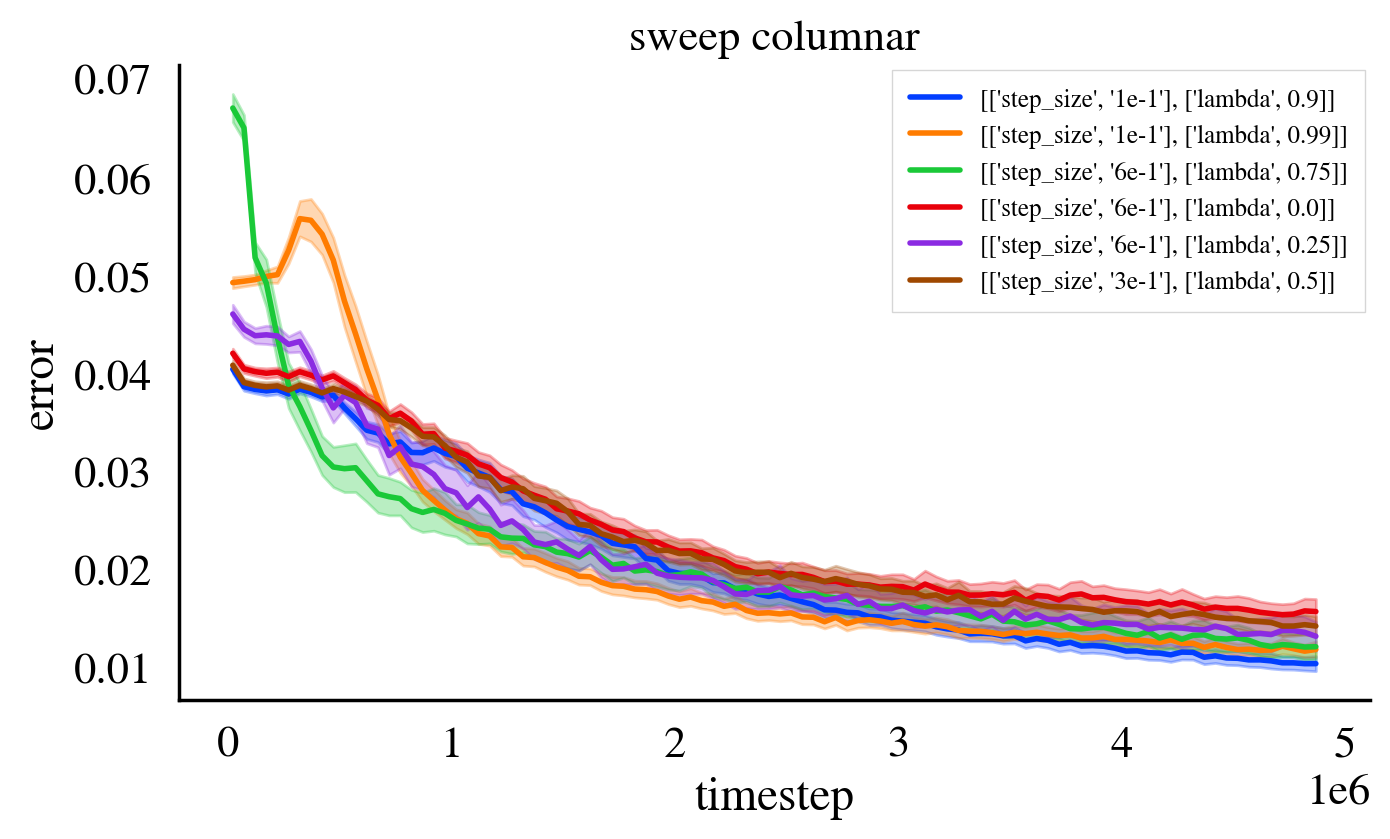

In [42]:
plt_name = f'sweep columnar'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=10)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
p1 = pd.read_sql(f'select distinct(step_size) from runs', db1.conn).values.squeeze()
p2 = pd.read_sql(f'select distinct(lambda) from runs', db1.conn).values.squeeze()
for ss, lmbda in itertools.product(p1,p2):
    conditions = [['step_size', ss],
                 ['lambda', lmbda]]
    print("plotting: ", conditions)
    if plt_with_err("", 98, 4500000, db1, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['truncation', 1]]
	 30 runs for [['step_size', 0.3], ['truncation', 1]]
plotting:  [['step_size', 0.1], ['truncation', 1]]
	 30 runs for [['step_size', 0.1], ['truncation', 1]]
plotting:  [['step_size', 0.03], ['truncation', 1]]
	 30 runs for [['step_size', 0.03], ['truncation', 1]]
plotting:  [['step_size', 0.01], ['truncation', 1]]
	 30 runs for [['step_size', 0.01], ['truncation', 1]]
plotting:  [['step_size', 0.003], ['truncation', 1]]
	 30 runs for [['step_size', 0.003], ['truncation', 1]]
plotting:  [['step_size', 0.001], ['truncation', 1]]
	 30 runs for [['step_size', 0.001], ['truncation', 1]]
plotting:  [['step_size', 0.0003], ['truncation', 1]]
	 30 runs for [['step_size', 0.0003], ['truncation', 1]]


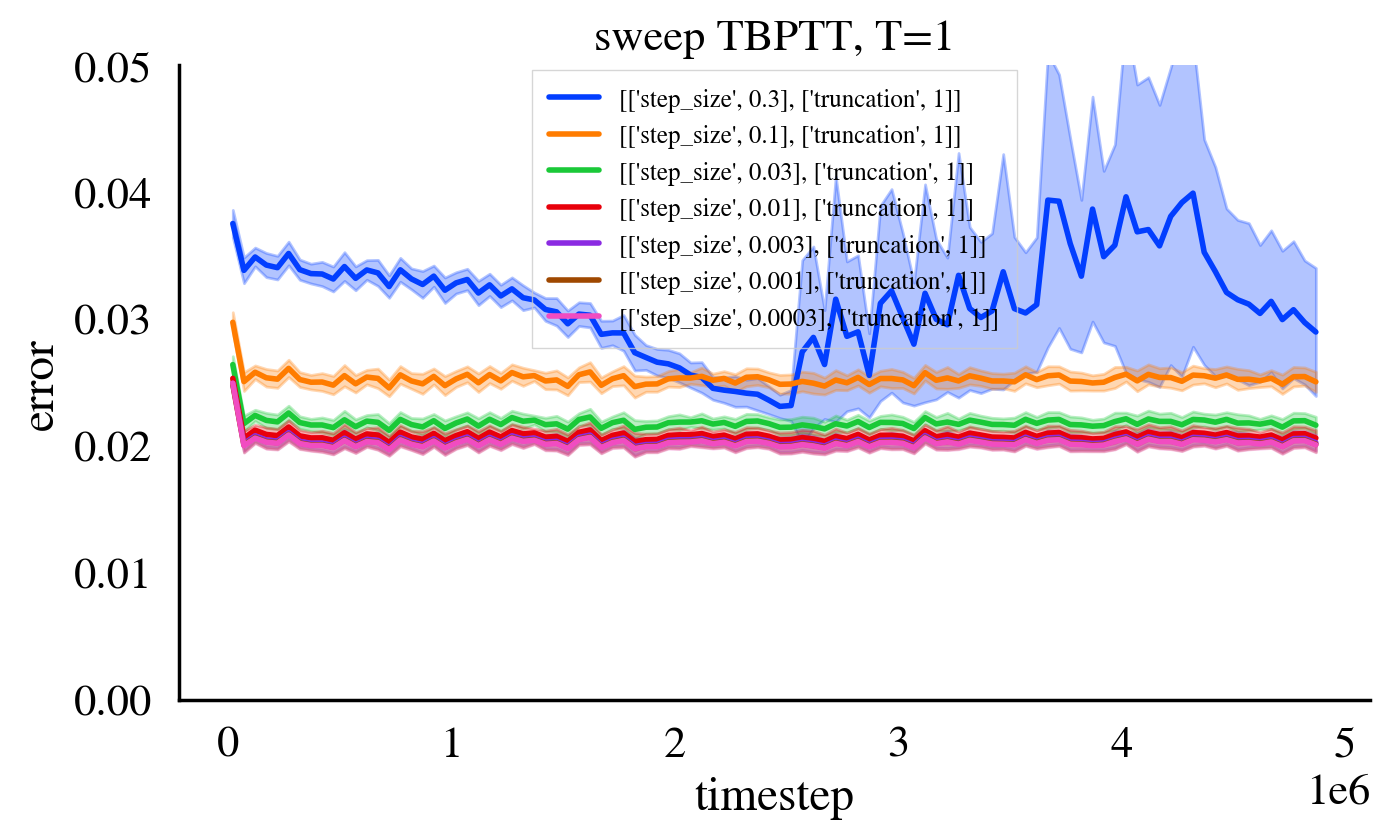

In [115]:
#pink is best
plt_name = f'sweep TBPTT, T=1'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=10)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for ss in pd.read_sql(f'select distinct(step_size) from runs', db2.conn).values.squeeze():
    conditions = [['step_size', ss],
                 ['truncation', 1]]
    print("plotting: ", conditions)
    if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['truncation', 5]]
	 29 runs for [['step_size', 0.3], ['truncation', 5]]
plotting:  [['step_size', 0.1], ['truncation', 5]]
	 30 runs for [['step_size', 0.1], ['truncation', 5]]
plotting:  [['step_size', 0.03], ['truncation', 5]]
	 30 runs for [['step_size', 0.03], ['truncation', 5]]
plotting:  [['step_size', 0.01], ['truncation', 5]]
	 30 runs for [['step_size', 0.01], ['truncation', 5]]
plotting:  [['step_size', 0.003], ['truncation', 5]]
	 30 runs for [['step_size', 0.003], ['truncation', 5]]
plotting:  [['step_size', 0.001], ['truncation', 5]]
	 30 runs for [['step_size', 0.001], ['truncation', 5]]
plotting:  [['step_size', 0.0003], ['truncation', 5]]
	 30 runs for [['step_size', 0.0003], ['truncation', 5]]


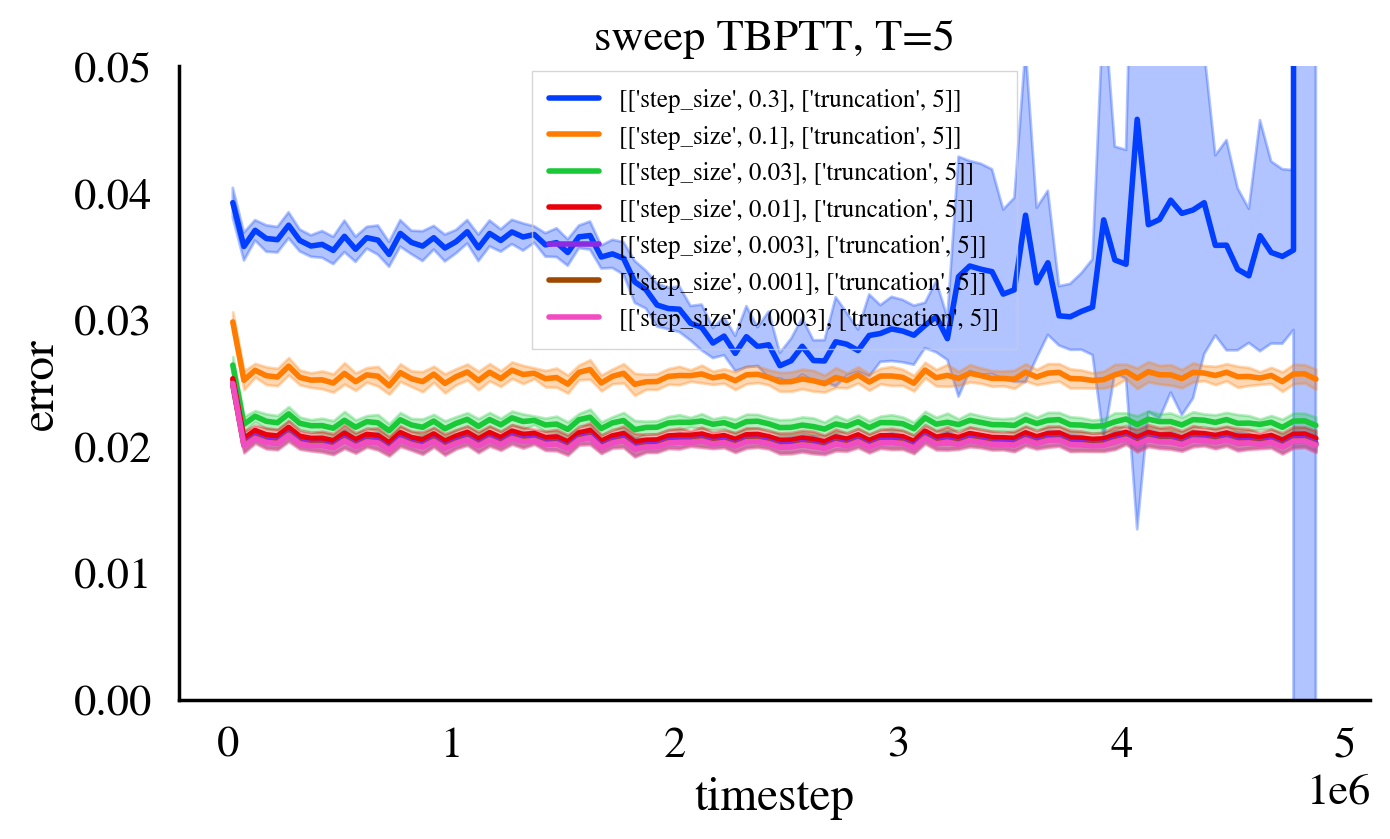

In [111]:
# pink is best
plt_name = f'sweep TBPTT, T=5'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=10)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for ss in pd.read_sql(f'select distinct(step_size) from runs', db2.conn).values.squeeze():
    conditions = [['step_size', ss],
                 ['truncation', 5]]
    print("plotting: ", conditions)
    if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['truncation', 10]]
	 30 runs for [['step_size', 0.3], ['truncation', 10]]
plotting:  [['step_size', 0.1], ['truncation', 10]]
	 30 runs for [['step_size', 0.1], ['truncation', 10]]
plotting:  [['step_size', 0.03], ['truncation', 10]]
	 30 runs for [['step_size', 0.03], ['truncation', 10]]
plotting:  [['step_size', 0.01], ['truncation', 10]]
	 30 runs for [['step_size', 0.01], ['truncation', 10]]
plotting:  [['step_size', 0.003], ['truncation', 10]]
	 30 runs for [['step_size', 0.003], ['truncation', 10]]
plotting:  [['step_size', 0.001], ['truncation', 10]]
	 30 runs for [['step_size', 0.001], ['truncation', 10]]
plotting:  [['step_size', 0.0003], ['truncation', 10]]
	 30 runs for [['step_size', 0.0003], ['truncation', 10]]


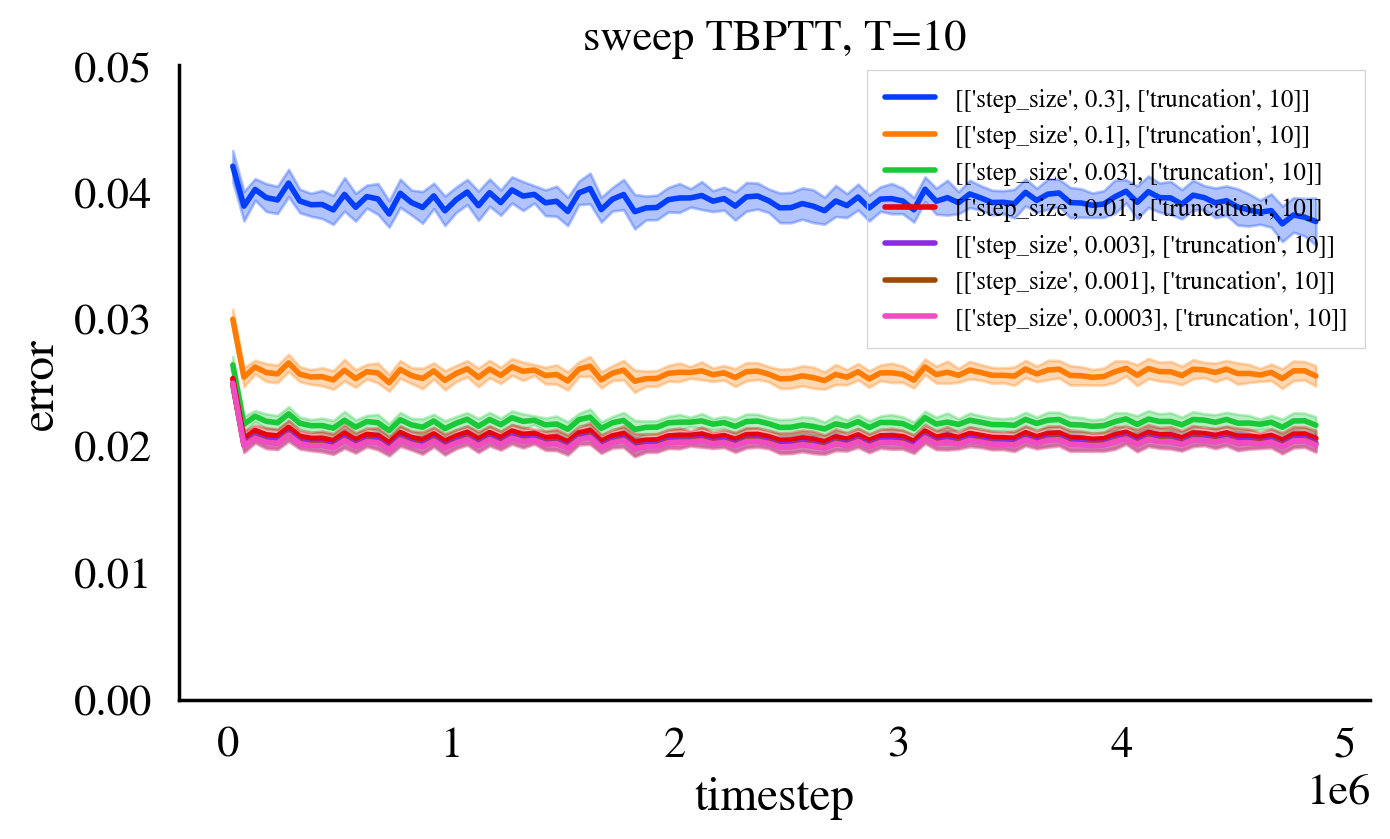

In [112]:
# is best
plt_name = f'sweep TBPTT, T=10'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=10)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for ss in pd.read_sql(f'select distinct(step_size) from runs', db2.conn).values.squeeze():
    conditions = [['step_size', ss],
                 ['truncation', 10]]
    print("plotting: ", conditions)
    if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['truncation', 20]]
	 30 runs for [['step_size', 0.3], ['truncation', 20]]
plotting:  [['step_size', 0.1], ['truncation', 20]]
	 30 runs for [['step_size', 0.1], ['truncation', 20]]
plotting:  [['step_size', 0.03], ['truncation', 20]]
	 30 runs for [['step_size', 0.03], ['truncation', 20]]
plotting:  [['step_size', 0.01], ['truncation', 20]]
	 30 runs for [['step_size', 0.01], ['truncation', 20]]
plotting:  [['step_size', 0.003], ['truncation', 20]]
	 30 runs for [['step_size', 0.003], ['truncation', 20]]
plotting:  [['step_size', 0.001], ['truncation', 20]]
	 30 runs for [['step_size', 0.001], ['truncation', 20]]
plotting:  [['step_size', 0.0003], ['truncation', 20]]
	 30 runs for [['step_size', 0.0003], ['truncation', 20]]


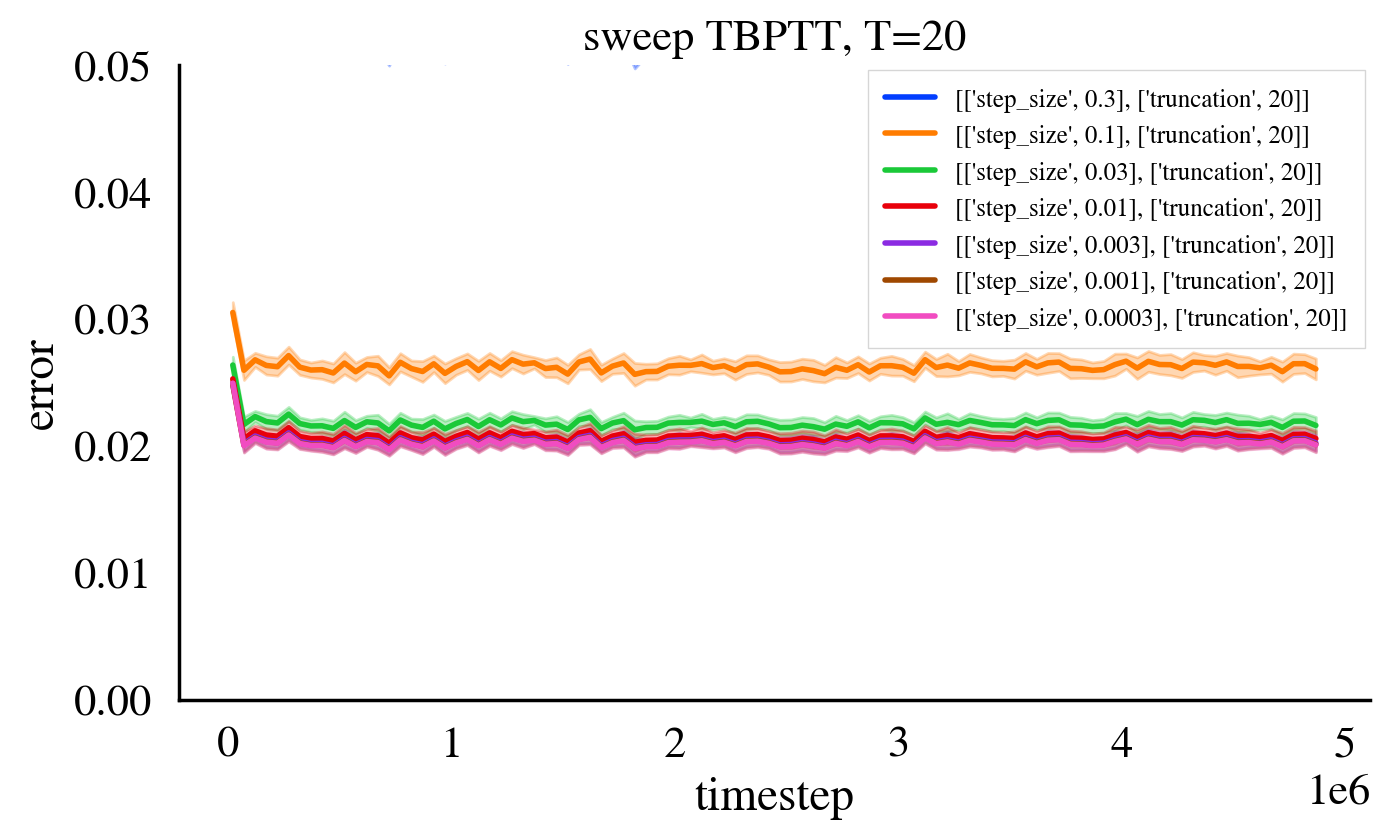

In [113]:
# is best
plt_name = f'sweep TBPTT, T=20'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=10)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for ss in pd.read_sql(f'select distinct(step_size) from runs', db2.conn).values.squeeze():
    conditions = [['step_size', ss],
                 ['truncation', 20]]
    print("plotting: ", conditions)
    if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['truncation', 50]]
	 0 runs for  [['step_size', 0.3], ['truncation', 50]]
plotting:  [['step_size', 0.1], ['truncation', 50]]
	 30 runs for [['step_size', 0.1], ['truncation', 50]]
plotting:  [['step_size', 0.03], ['truncation', 50]]
	 30 runs for [['step_size', 0.03], ['truncation', 50]]
plotting:  [['step_size', 0.01], ['truncation', 50]]
	 30 runs for [['step_size', 0.01], ['truncation', 50]]
plotting:  [['step_size', 0.003], ['truncation', 50]]
	 30 runs for [['step_size', 0.003], ['truncation', 50]]
plotting:  [['step_size', 0.001], ['truncation', 50]]
	 30 runs for [['step_size', 0.001], ['truncation', 50]]
plotting:  [['step_size', 0.0003], ['truncation', 50]]
	 30 runs for [['step_size', 0.0003], ['truncation', 50]]


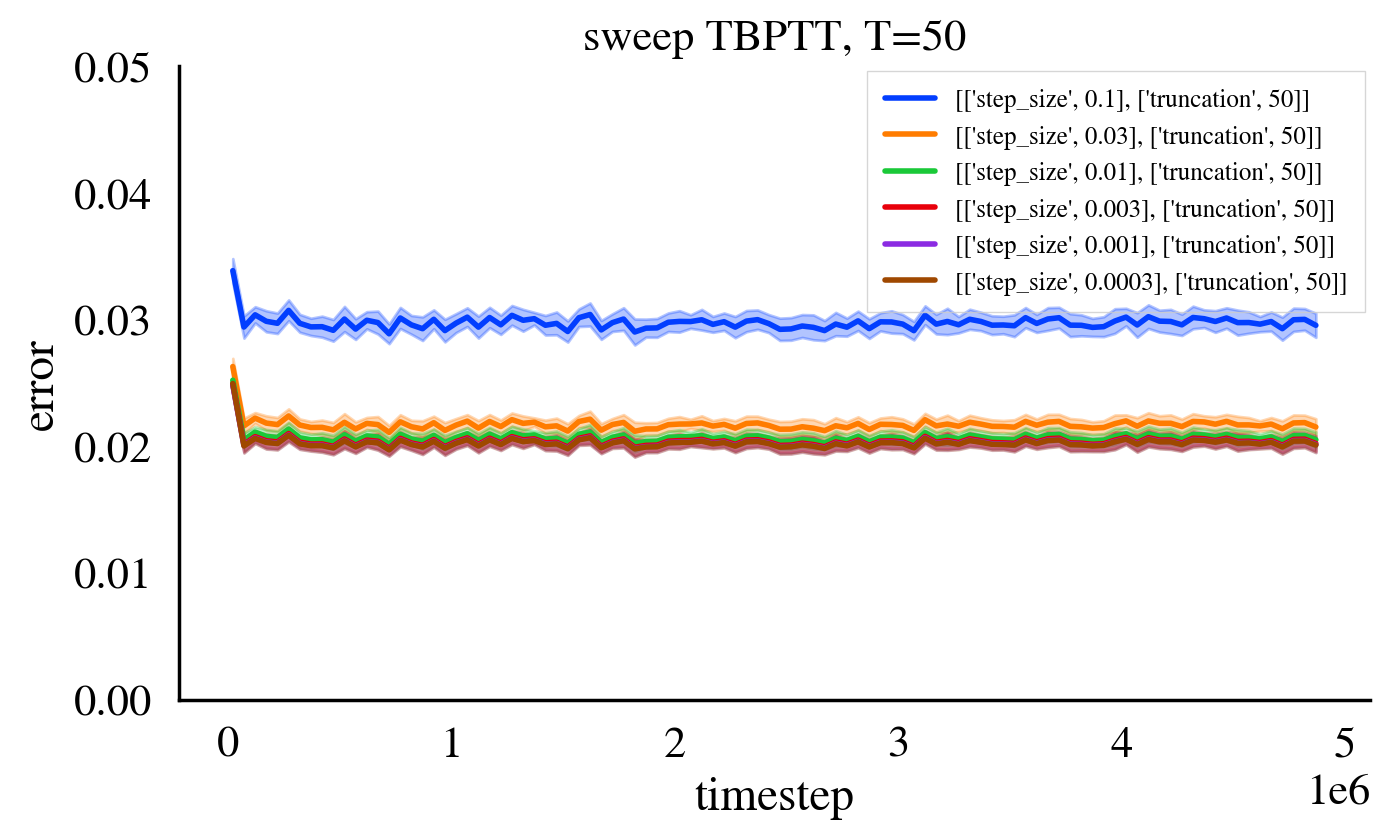

In [114]:
# brown is best
plt_name = f'sweep TBPTT, T=50'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=10)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for ss in pd.read_sql(f'select distinct(step_size) from runs', db2.conn).values.squeeze():
    conditions = [['step_size', ss],
                 ['truncation', 50]]
    print("plotting: ", conditions)
    if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

## Combined comparison plot 
not all runs included yet

	 150 runs for [['step_size', 0.1], ['lambda', 0.9]]
	 30 runs for [['step_size', 0.0003], ['truncation', 1]]
	 30 runs for [['step_size', 0.0003], ['truncation', 5]]
	 30 runs for [['step_size', 0.0003], ['truncation', 10]]
	 30 runs for [['step_size', 0.0003], ['truncation', 20]]
	 30 runs for [['step_size', 0.0003], ['truncation', 50]]


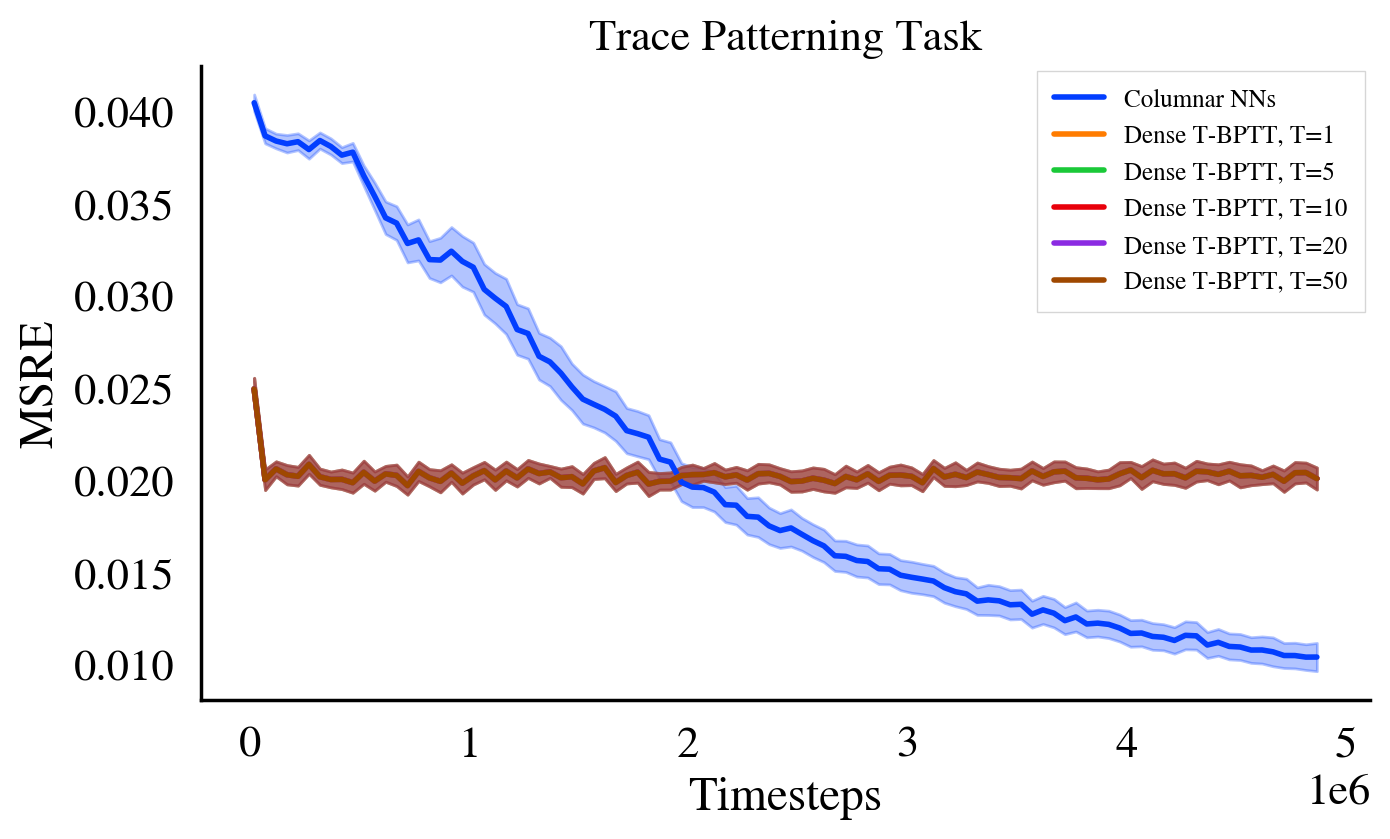

In [116]:
#TODO is this really MSRE or TD err in tables? check again
plt_name = f'Trace Patterning Task'
plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0


conditions = [['step_size', 1e-1],
             ['lambda', 0.9]]
plt_with_err("", 98, 4500000, db1, colors[color_idx], "Columnar NNs", conditions, "error_table", True, pkey_col = "run", nocomment=True)
color_idx+=1

conditions = [['step_size', 0.0003],
             ['truncation', 1]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Dense T-BPTT, T=1", conditions, "error_table", True, pkey_col = "run", nocomment=True)
color_idx+=1

conditions = [['step_size', 0.0003],
             ['truncation', 5]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Dense T-BPTT, T=5", conditions, "error_table", True, pkey_col = "run", nocomment=True)
color_idx+=1

conditions = [['step_size', 0.0003],
             ['truncation', 10]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Dense T-BPTT, T=10", conditions, "error_table", True, pkey_col = "run", nocomment=True)
color_idx+=1

conditions = [['step_size', 0.0003],
             ['truncation', 20]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Dense T-BPTT, T=20", conditions, "error_table", True, pkey_col = "run", nocomment=True)
color_idx+=1

conditions = [['step_size', 0.0003],
             ['truncation', 50]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Dense T-BPTT, T=50", conditions, "error_table", True, pkey_col = "run", nocomment=True)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 9})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figures/plt_animal.pdf', bbox_inches='tight')
plt.show()